# Experiment 2: Data exploration and analysis

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from scipy.stats import chi2_contingency
from PIL import Image

from pathlib import Path

if not Path("images_exp2").exists():
    Path("images_exp2").mkdir(parents=True)
warnings.filterwarnings('ignore')

## Load dataset

In [2]:
exp_full = pd.read_csv('../experiments/Altruism_RMAI_experiment2.csv', skiprows=[0, 1, 2, 3, 4, 5])
step_col = exp_full.pop("[step]")
exp_full.insert(1, "step", step_col)
exp_full = exp_full.rename(columns={"[run number]": "run-number"}).sort_values(by=['run-number', 'step'])
exp_full.head(10)

,run-number,step,occupation-var,initial-patch-harshness,prob-gain-resource,stride-length,agent-move-cost,energy-gain,altruism-resource-threshold,reproduction-var,initial-patch-resource,initial-population,initial-agent-energy,altruism-prob,repeat-diffusion,count altruism-agents,count greedy-agents
0,1,0,0.1,5,0.2,0.01,10,50,20,0.5,50,100,100,0.5,2,42,58
17,1,1,0.1,5,0.2,0.01,10,50,20,0.5,50,100,100,0.5,2,42,58
21,1,2,0.1,5,0.2,0.01,10,50,20,0.5,50,100,100,0.5,2,84,116
32,1,3,0.1,5,0.2,0.01,10,50,20,0.5,50,100,100,0.5,2,84,116
44,1,4,0.1,5,0.2,0.01,10,50,20,0.5,50,100,100,0.5,2,84,116
55,1,5,0.1,5,0.2,0.01,10,50,20,0.5,50,100,100,0.5,2,84,116
68,1,6,0.1,5,0.2,0.01,10,50,20,0.5,50,100,100,0.5,2,168,230
80,1,7,0.1,5,0.2,0.01,10,50,20,0.5,50,100,100,0.5,2,168,230
92,1,8,0.1,5,0.2,0.01,10,50,20,0.5,50,100,100,0.5,2,168,232
99,1,9,0.1,5,0.2,0.01,10,50,20,0.5,50,100,100,0.5,2,168,232


## Check summary statistics

In [3]:
COLS_TO_OMIT = ['run-number', 'step', 'count altruism-agents', 'count greedy-agents']

summary = exp_full.describe().T
summary

,count,mean,std,min,25%,50%,75%,max
run-number,1361373.0,6740.584403,3892.056324,1.00,3370.00,6740.0,10110.0,13500.0
step,1361373.0,49.986521,29.157782,0.00,25.00,50.0,75.0,100.0
occupation-var,1361373.0,0.499379,0.257921,0.10,0.30,0.5,0.7,0.9
initial-patch-harshness,1361373.0,27.478953,14.360629,5.00,15.00,25.0,40.0,50.0
prob-gain-resource,1361373.0,0.600170,0.282812,0.20,0.40,0.6,0.8,1.0
stride-length,1361373.0,0.193338,0.167470,0.01,0.05,0.2,0.3,0.5
agent-move-cost,1361373.0,10.000000,0.000000,10.00,10.00,10.0,10.0,10.0
energy-gain,1361373.0,50.000000,0.000000,50.00,50.00,50.0,50.0,50.0
altruism-resource-threshold,1361373.0,20.000000,0.000000,20.00,20.00,20.0,20.0,20.0
reproduction-var,1361373.0,0.500000,0.000000,0.50,0.50,0.5,0.5,0.5


## Plot 3 x 5 random experiments 

Each plot contains 5 runs with the same variables.

In [4]:
def plot_random_experiment(exp_full: pd.DataFrame, n=3):
    variables = [col for col in exp_full.columns if col not in COLS_TO_OMIT]
    unique_combinations = exp_full.drop_duplicates(subset=variables)[variables]
    selected_combinations = unique_combinations.sample(n)
    
    for _, row in selected_combinations.iterrows():
        filtered_exp_full = exp_full[(exp_full[variables] == row).all(axis=1)]
        run_numbers = filtered_exp_full['run-number'].unique().tolist()
        plt.figure(figsize=(10, 6))
        for run_number in run_numbers:
            filtered_exp_run = filtered_exp_full[(filtered_exp_full['run-number'] == run_number)]
            sns.lineplot(data=filtered_exp_run, x='step', y='count altruism-agents', label='Altruists', color='blue')
            sns.lineplot(data=filtered_exp_run, x='step', y='count greedy-agents', label='Greedy', color='red' )
            plt.fill_between(filtered_exp_run['step'], filtered_exp_run['count altruism-agents'], alpha=0.1, color='blue')
            plt.fill_between(filtered_exp_run['step'], filtered_exp_run['count greedy-agents'], alpha=0.1, color='red')
    
        plt.title('Run numbers: ' + str(run_numbers)) 
        plt.figtext(1, 0.5, row)
        plt.ylabel('Count')
        plt.xlabel('Step')
        handles, labels = plt.gca().get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        plt.legend(by_label.values(), by_label.keys(), title='Agent Type')
        plt.tight_layout()

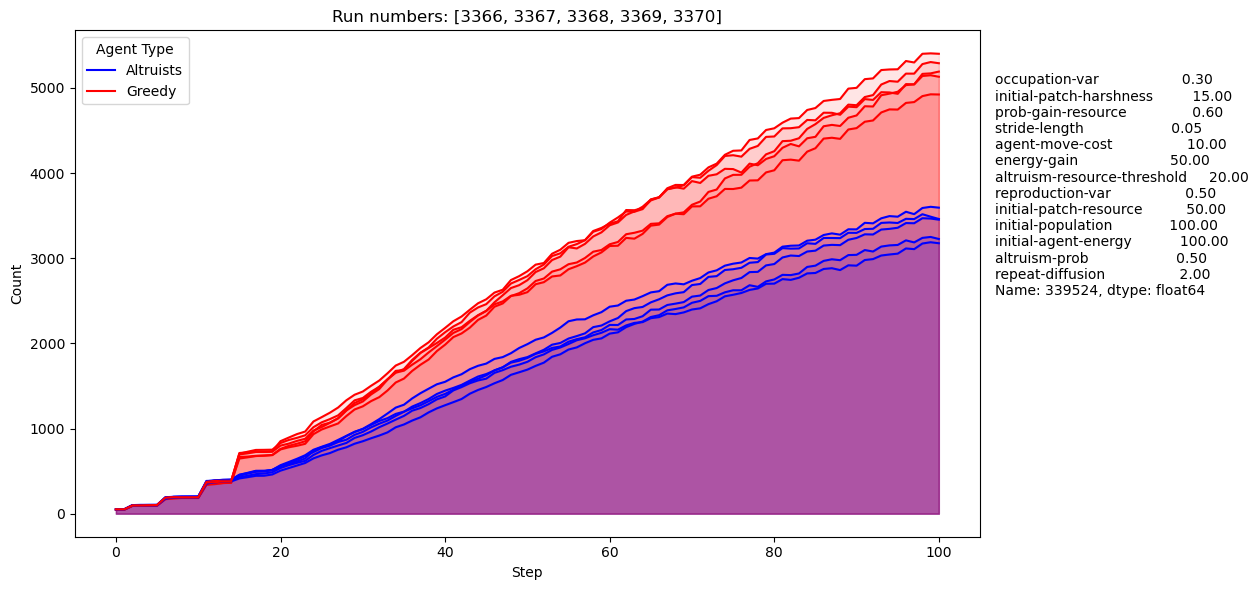

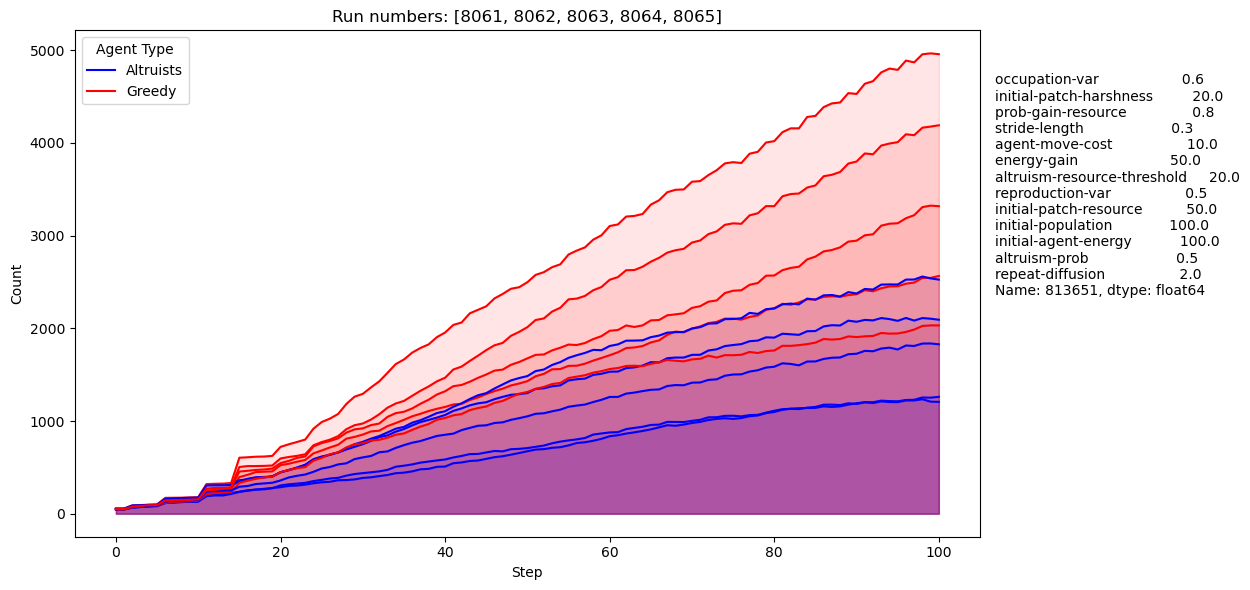

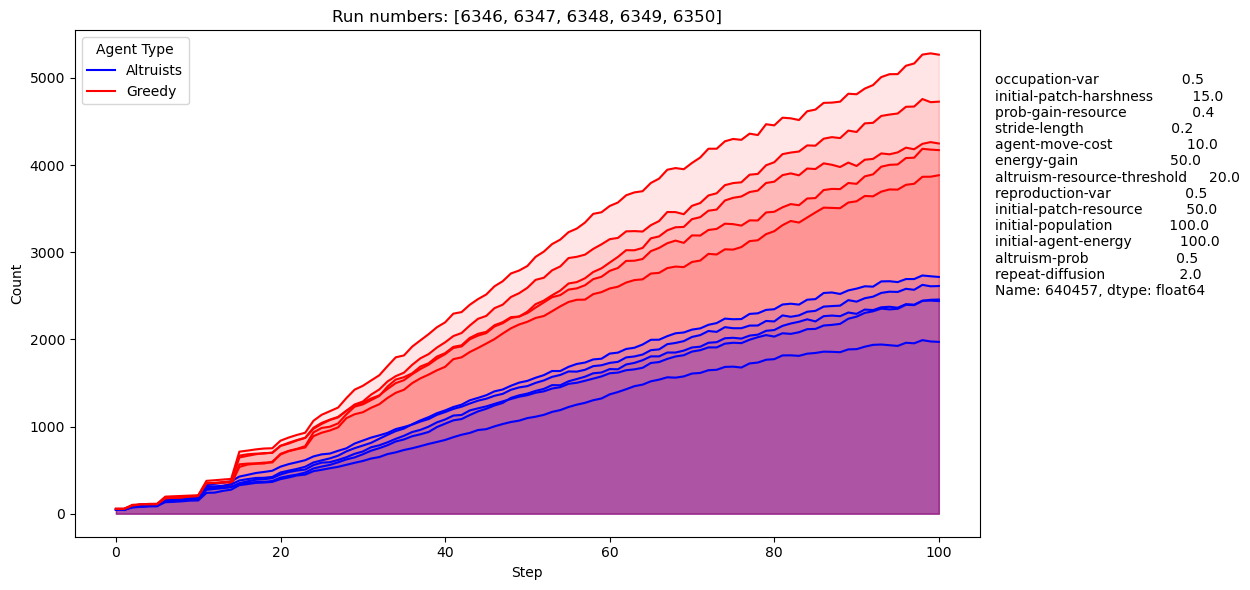

In [5]:
plot_random_experiment(exp_full)

## Filter down to end states

In [6]:
exp = exp_full[exp_full["step"] == exp_full.groupby(['run-number'])['step'].transform('max')]
exp.head(10)

,run-number,step,occupation-var,initial-patch-harshness,prob-gain-resource,stride-length,agent-move-cost,energy-gain,altruism-resource-threshold,reproduction-var,initial-patch-resource,initial-population,initial-agent-energy,altruism-prob,repeat-diffusion,count altruism-agents,count greedy-agents
997,1,100,0.1,5,0.2,0.01,10,50,20,0.5,50,100,100,0.5,2,2608,7666
992,2,100,0.1,5,0.2,0.01,10,50,20,0.5,50,100,100,0.5,2,2814,6675
983,3,100,0.1,5,0.2,0.01,10,50,20,0.5,50,100,100,0.5,2,3129,6618
999,4,100,0.1,5,0.2,0.01,10,50,20,0.5,50,100,100,0.5,2,3544,6210
1008,5,100,0.1,5,0.2,0.01,10,50,20,0.5,50,100,100,0.5,2,3296,6409
989,6,100,0.1,5,0.2,0.05,10,50,20,0.5,50,100,100,0.5,2,2562,6760
1065,7,100,0.1,5,0.2,0.05,10,50,20,0.5,50,100,100,0.5,2,3227,7260
1004,8,100,0.1,5,0.2,0.05,10,50,20,0.5,50,100,100,0.5,2,3555,6735
1013,9,100,0.1,5,0.2,0.05,10,50,20,0.5,50,100,100,0.5,2,3927,5699
1010,10,100,0.1,5,0.2,0.05,10,50,20,0.5,50,100,100,0.5,2,3242,6821


## Find runs that finished early

In [7]:
exp_early_finish = exp[exp["step"] < 100]

Check the total count of the agents in the runs that finished early, looks like Behaviour Space does not persist the step where the number of agents hits zero, but ends on the step just before.

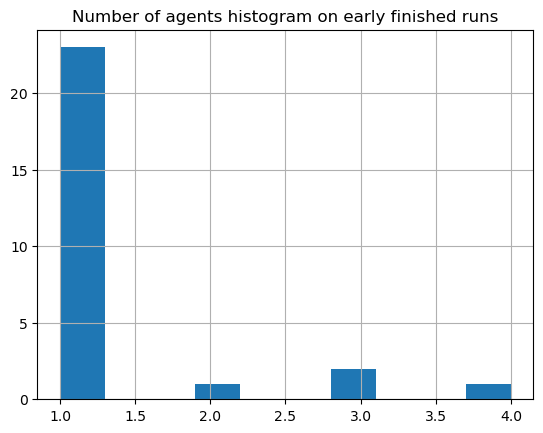

In [8]:

exp_early_finish[['count greedy-agents', 'count altruism-agents']].sum(axis=1).hist()
plt.title('Number of agents histogram on early finished runs')
plt.show()

## We filter out the early finishers

In [9]:
exp = exp[exp['step'] == 100].drop(columns=['step'])

In [10]:
exp_full = exp_full[exp_full['run-number'].isin(exp['run-number'])]

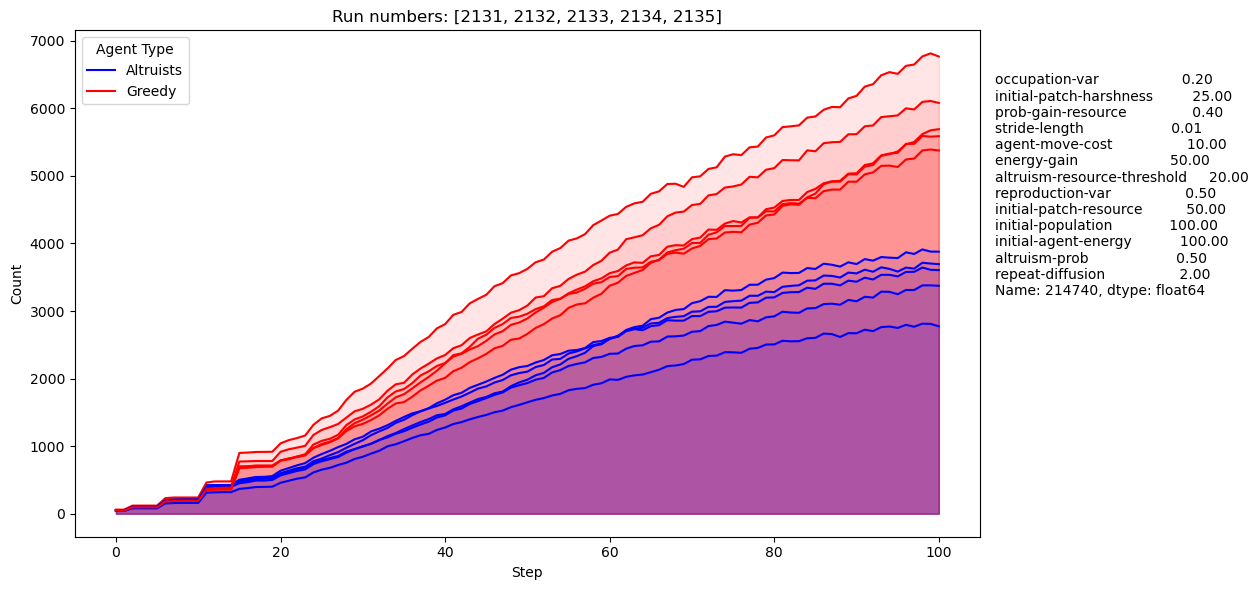

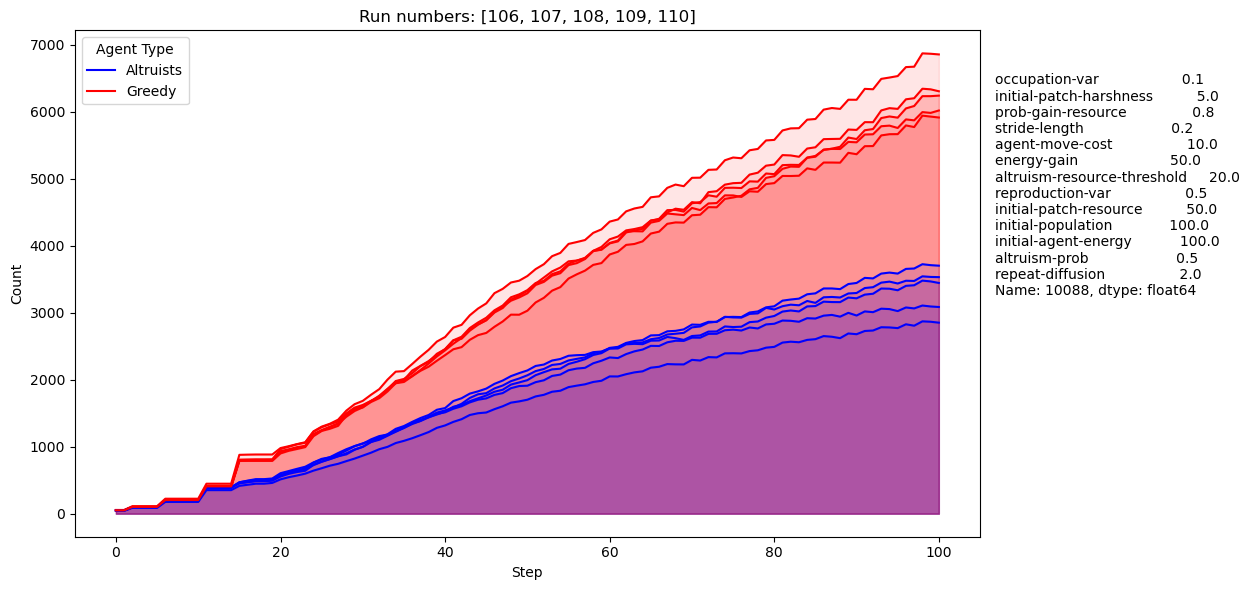

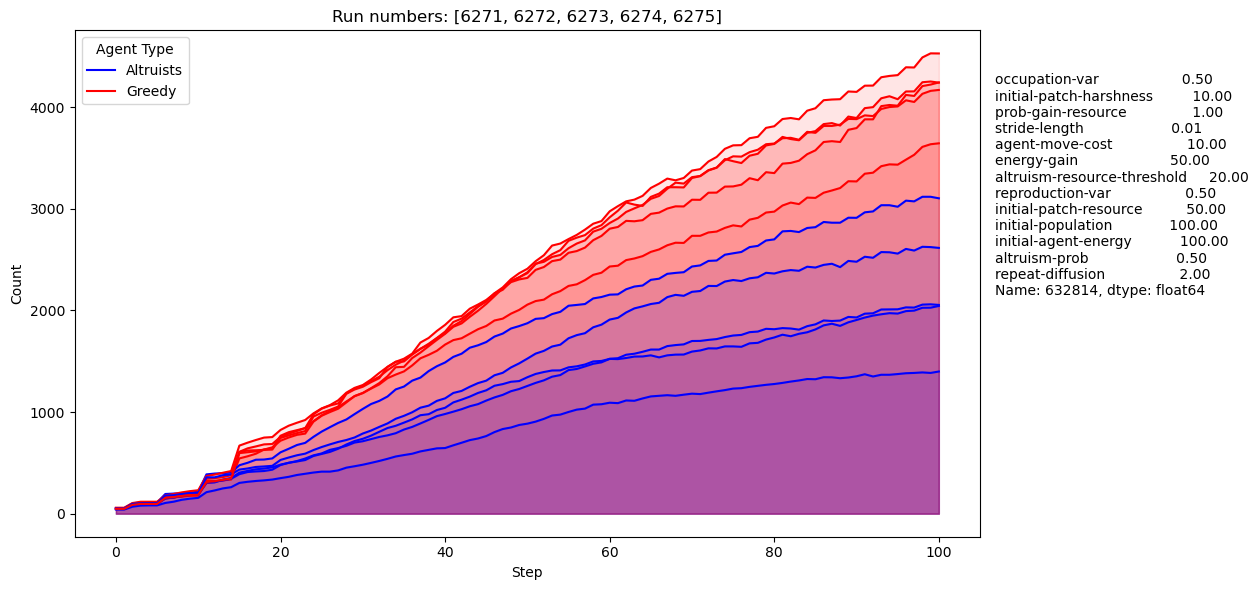

In [11]:
plot_random_experiment(exp_full)

## We look at the distributions of the varying inputs in different cases

In [12]:
varying_inputs = [i for i in summary.index if summary.loc[i]['min'] != summary.loc[i]['max'] and i not in COLS_TO_OMIT]
varying_inputs

['occupation-var',
 'initial-patch-harshness',
 'prob-gain-resource',
 'stride-length']

In [13]:
small_vars = ['occupation-var',
 'reproduction-var',
 'prob-gain-resource',
 'stride-length',
]
large_vars = [col for col in varying_inputs if col not in small_vars]
  
def strip_plots(end_states_df, title):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))
    melted_small = end_states_df.melt(value_vars=small_vars, var_name='Variable', value_name='Value')
    melted_large = end_states_df.melt(value_vars=large_vars, var_name='Variable', value_name='Value')

    sns.stripplot(x='Variable', y='Value', data=melted_small, ax=axes[0], dodge=True, alpha=0.01, size=10)
    axes[0].set_title('Small Ranges')
    axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45)
    axes[0].set_xlabel('')
    axes[0].set_ylabel('Value')
    
    sns.stripplot(x='Variable', y='Value', data=melted_large, ax=axes[1],  dodge=True, alpha=0.01, size=10)
    axes[1].set_title('Large Ranges')
    axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45)
    axes[1].set_xlabel('')
    axes[1].set_ylabel('')
    
    plt.tight_layout()
    plt.figtext(0.5, 0, title)
    plt.show()
    

def plot_histograms_grid(data, title):
    # Determine grid size
    n_vars = len(varying_inputs)
    n_cols = 2  # You can adjust the number of columns based on your preference
    n_rows = np.ceil(n_vars / n_cols).astype(int)

    # Create figure and axes
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(n_cols * 5, n_rows * 4))
    fig.suptitle(title)

    # Flatten axes array for easy indexing
    axes = axes.flatten()

    # Plot each variable
    for i, var in enumerate(varying_inputs):
        sns.histplot(data[var], ax=axes[i], kde=False, bins=20)
        axes[i].set_title(var)
        axes[i].set_xlabel('')
        axes[i].set_ylabel('Frequency')

    # Hide unused subplots if any
    for j in range(i + 1, n_rows * n_cols):
        axes[j].set_visible(False)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust the layout to make room for the main title
    plt.show()
    

#### No altruists left

Let us look at a few cases where the altruists went extinct.

In [14]:
exp.shape

(13473, 16)

Number of runs with no Altruists: 29


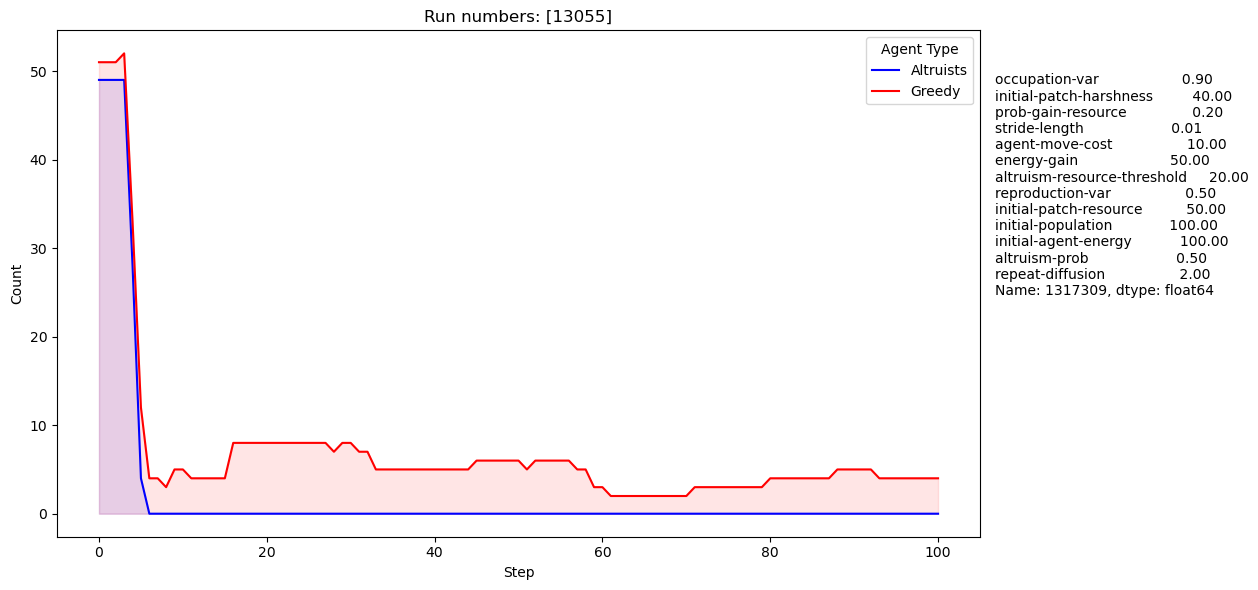

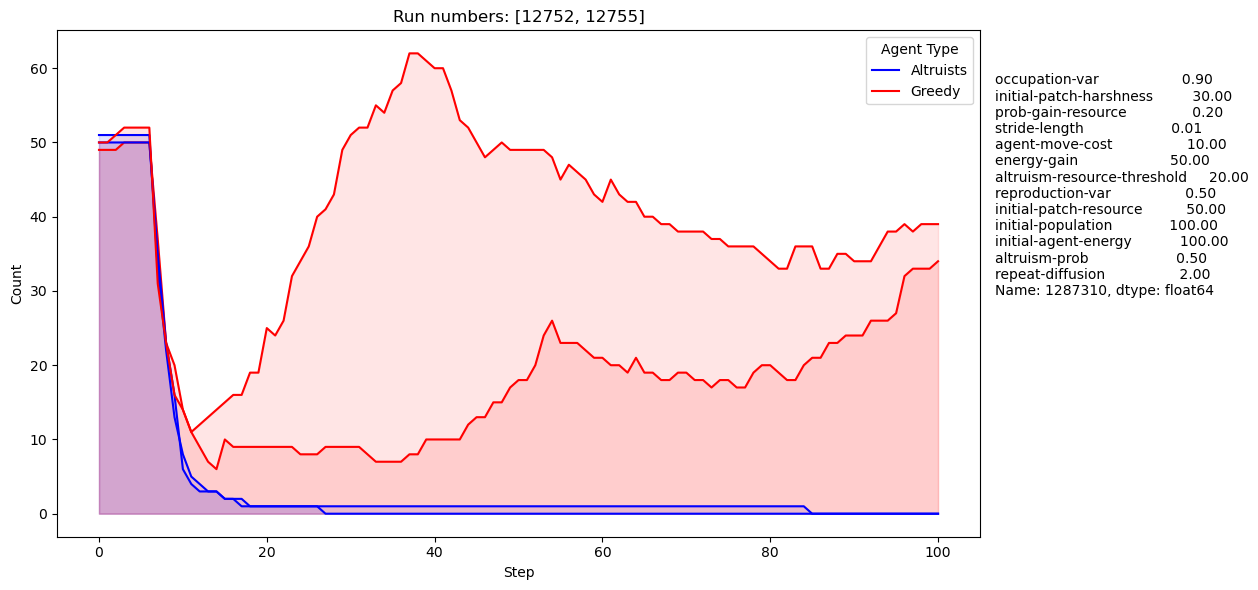

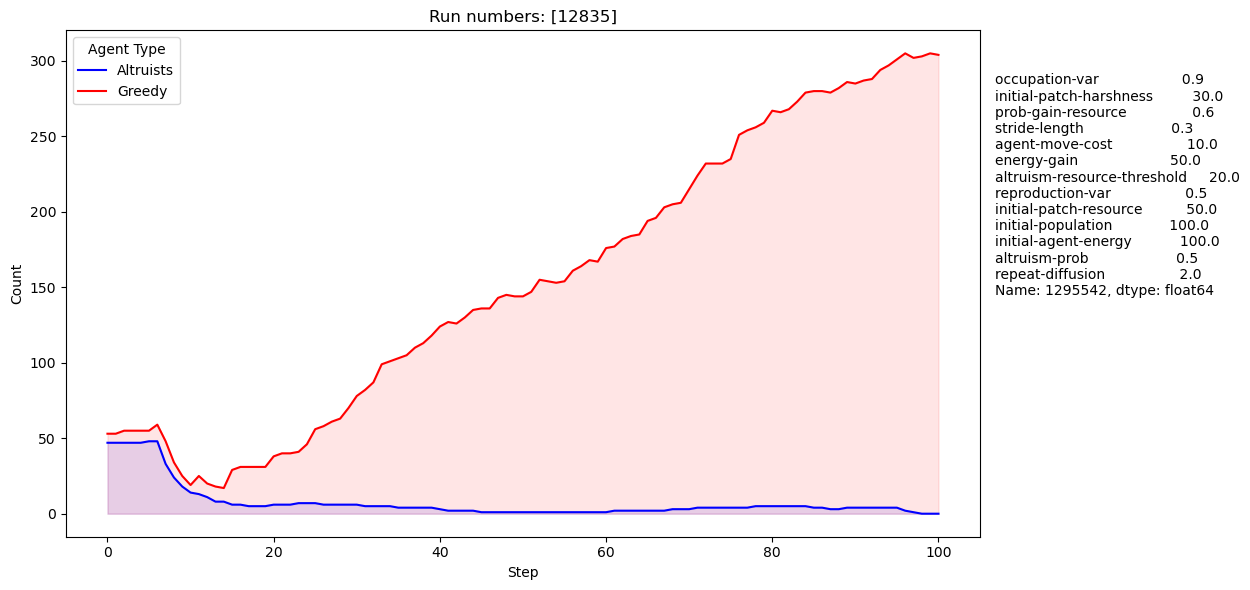

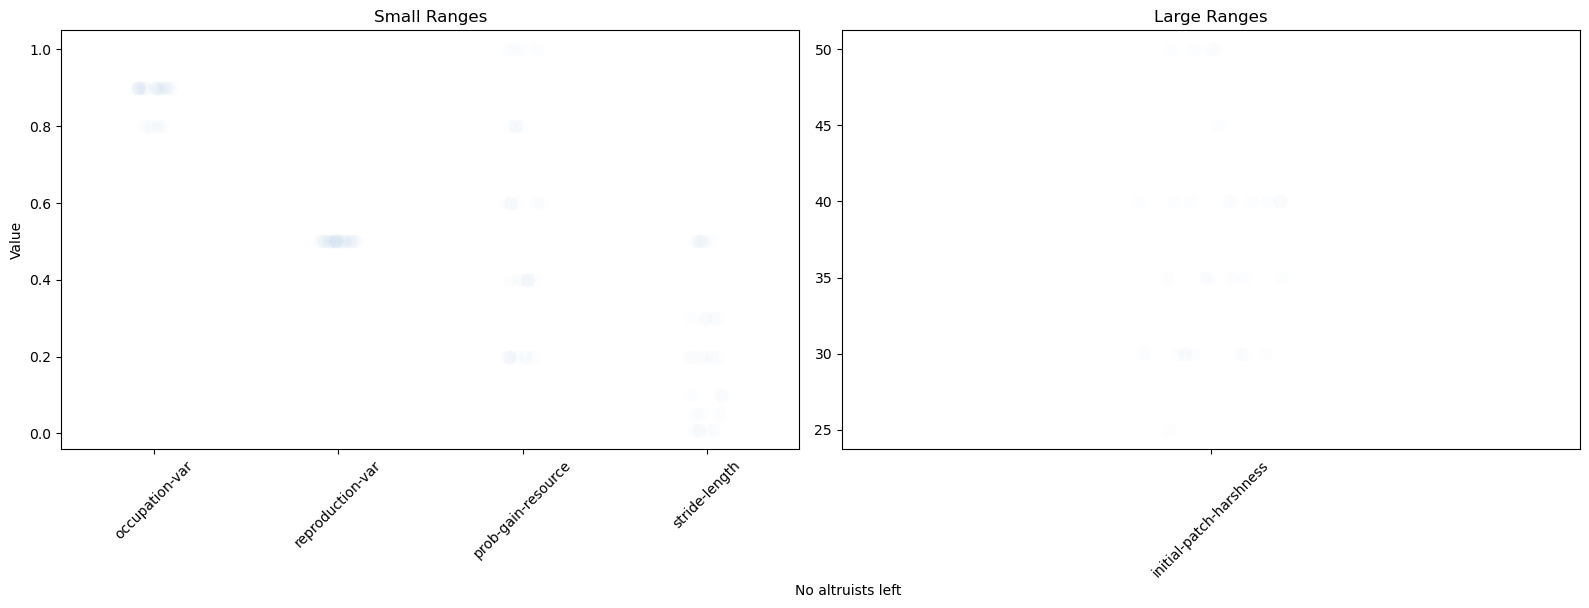

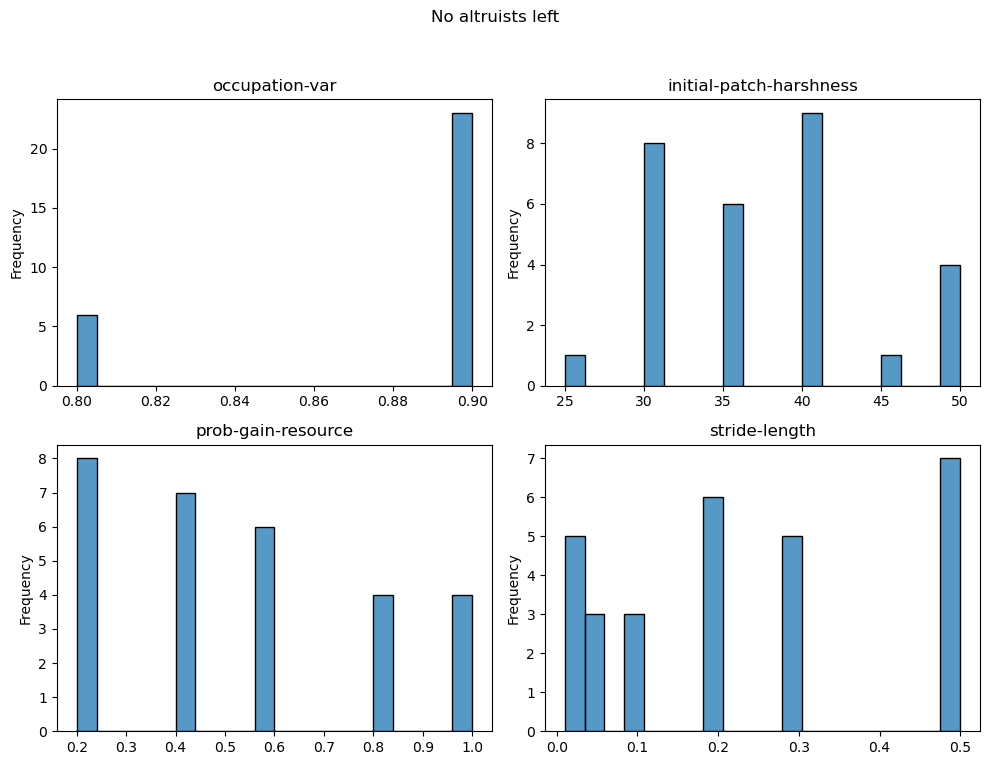

In [36]:
exp_no_altruists = exp[exp['count altruism-agents'] == 0]
exp_full_no_alruists = exp_full[exp_full['run-number'].isin(exp_no_altruists['run-number'])]
print('Number of runs with no Altruists:', len(exp_no_altruists))
plot_random_experiment(exp_full_no_alruists)
strip_plots(exp_no_altruists, 'No altruists left')
plot_histograms_grid(exp_no_altruists, 'No altruists left')

#### No greedy agents left

Now let us look at the case where there are no greedy agents left.

Number of runs with no greedy agents 15


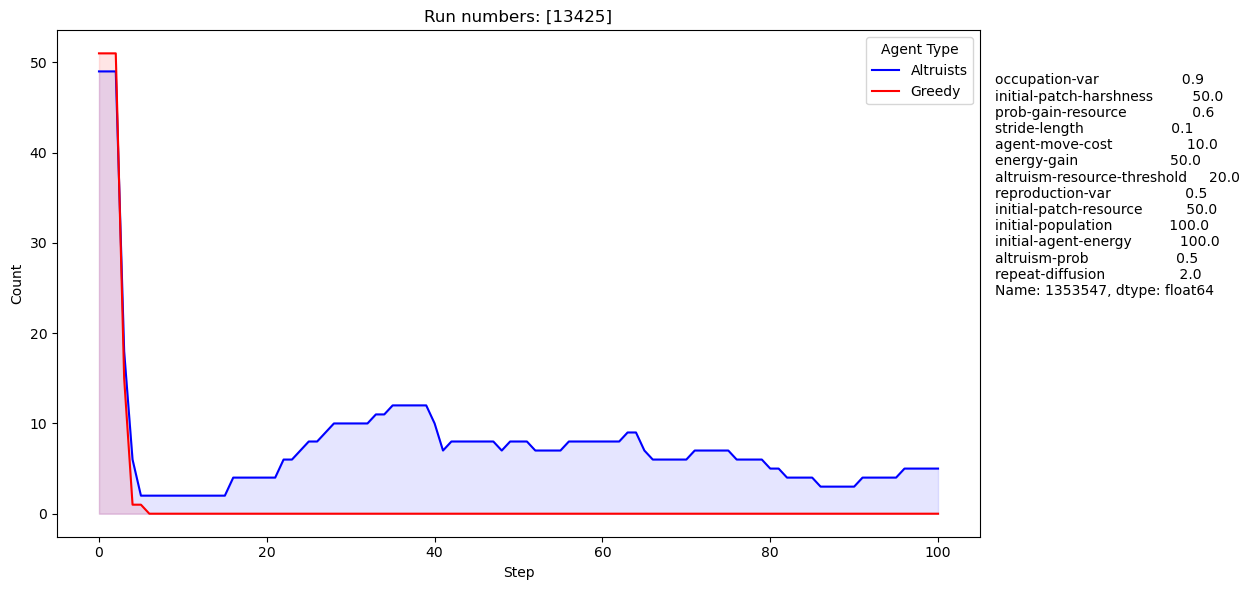

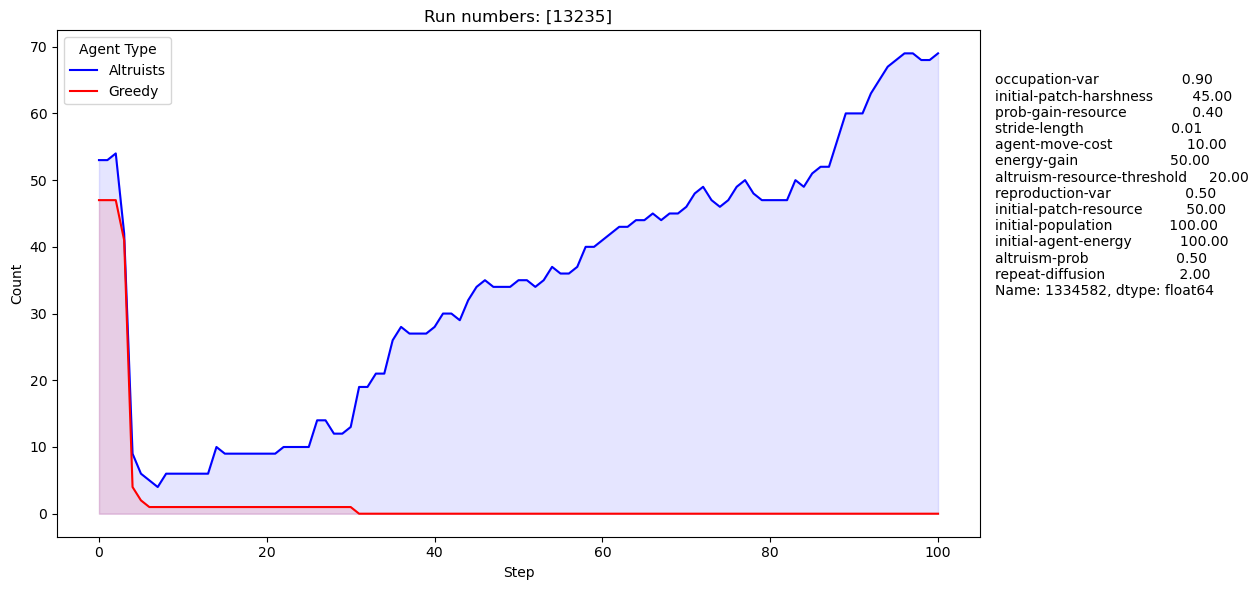

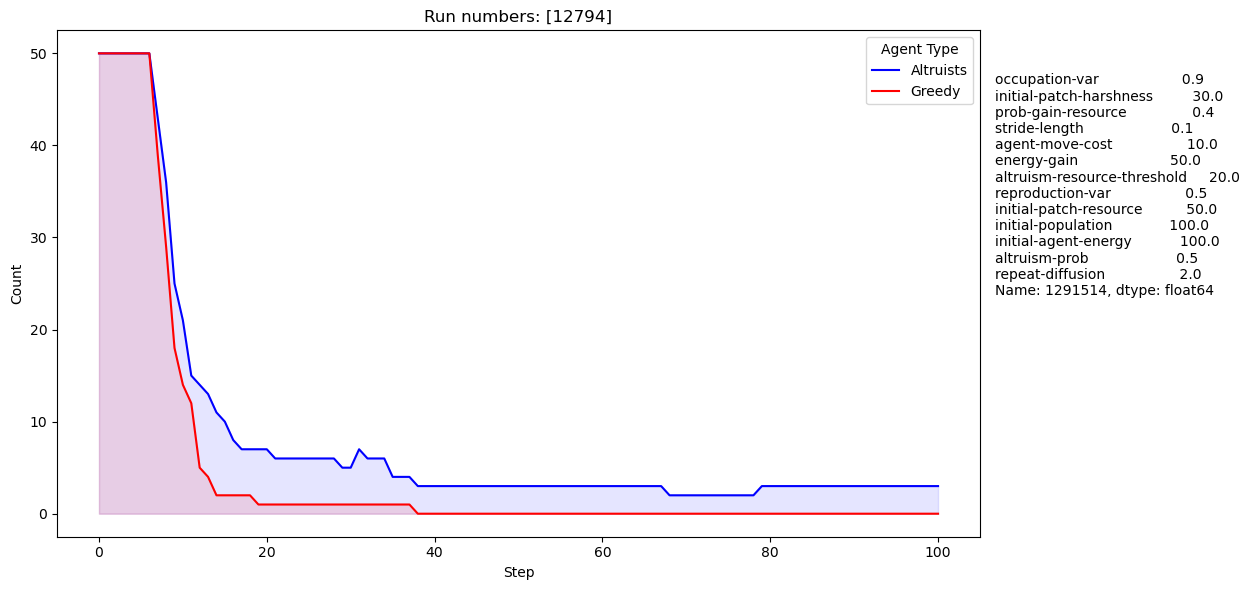

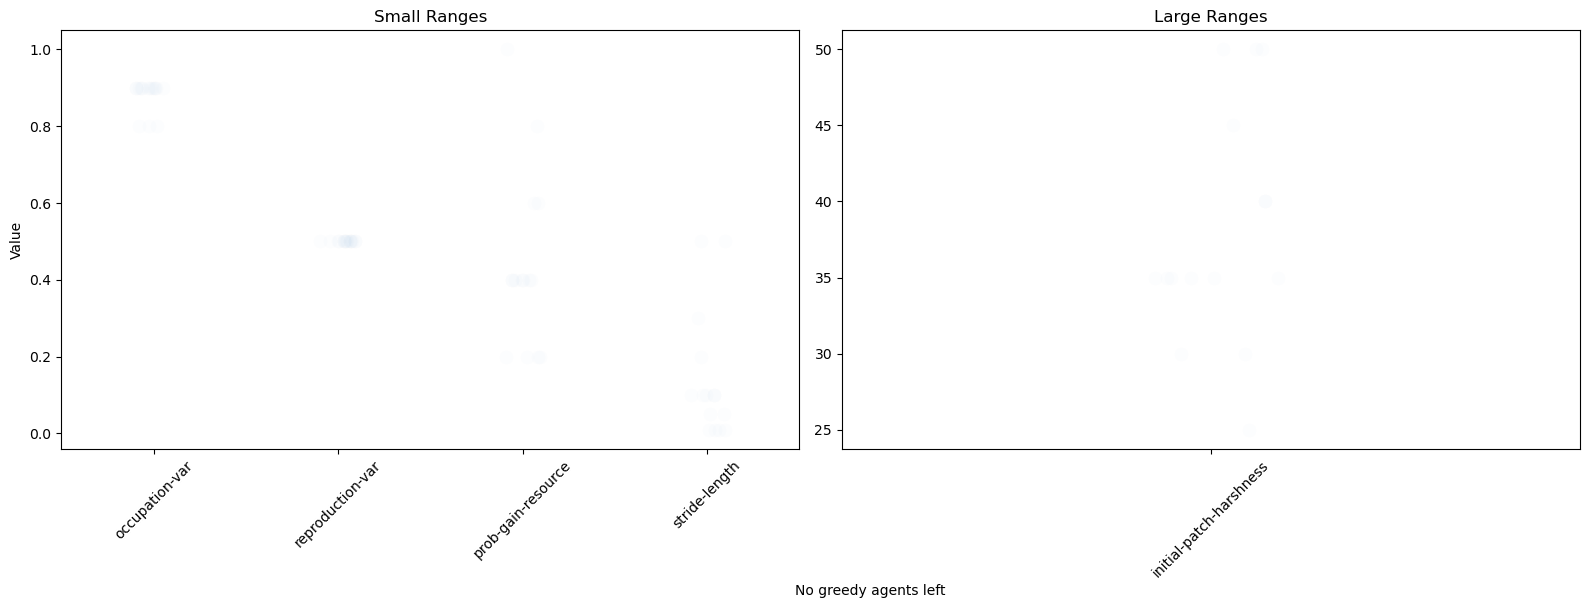

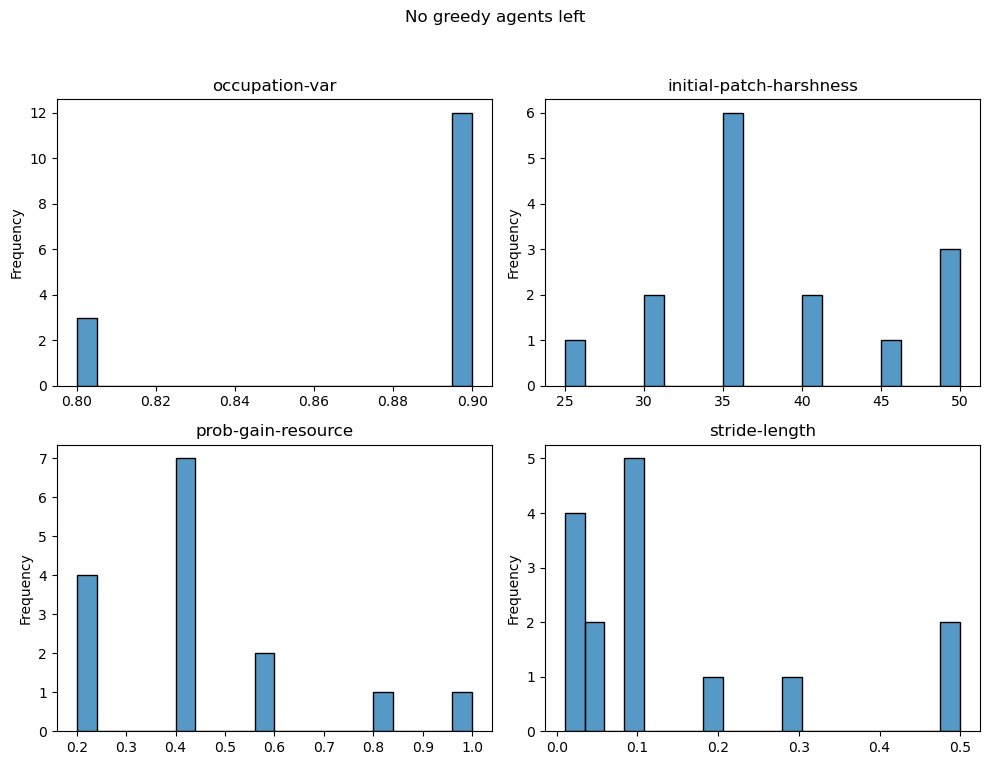

In [37]:
exp_no_greedy = exp[exp['count greedy-agents'] == 0]
exp_full_no_greedy = exp_full[exp_full['run-number'].isin(exp_no_greedy['run-number'])]
print('Number of runs with no greedy agents', len(exp_no_greedy))
plot_random_experiment(exp_full_no_greedy) 
strip_plots(exp_no_greedy, 'No greedy agents left')
plot_histograms_grid(exp_no_greedy, 'No greedy agents left')

#### Altruists survive

We can also look at some random cases where altruists survive the 100 iterations

Number of runs with surviving altruists: 13444


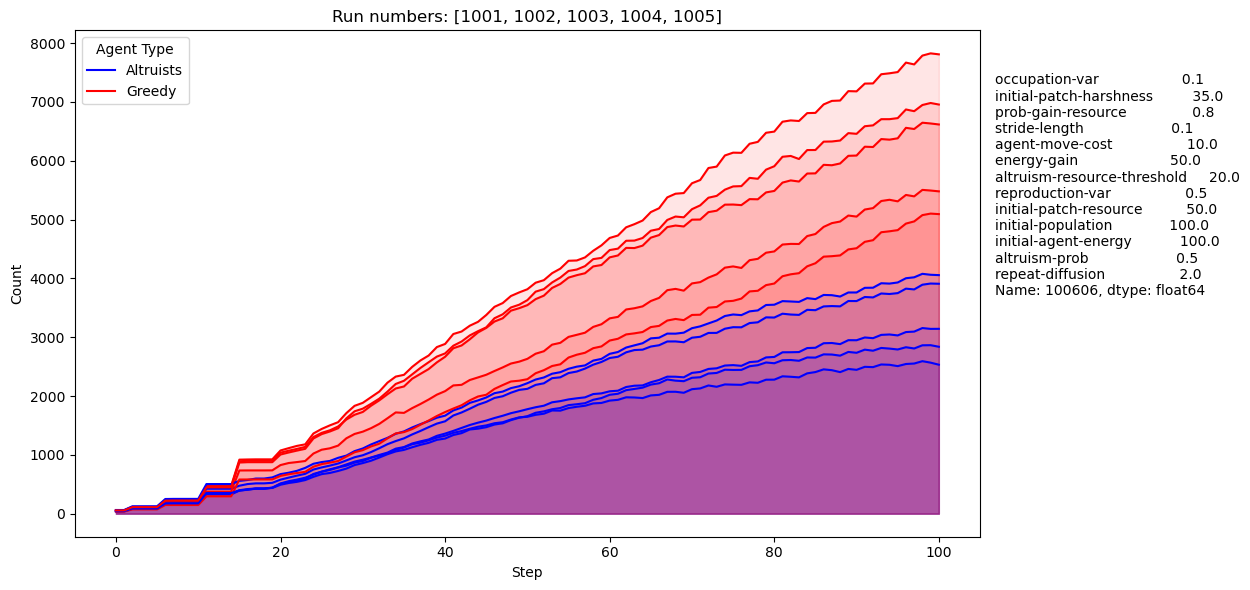

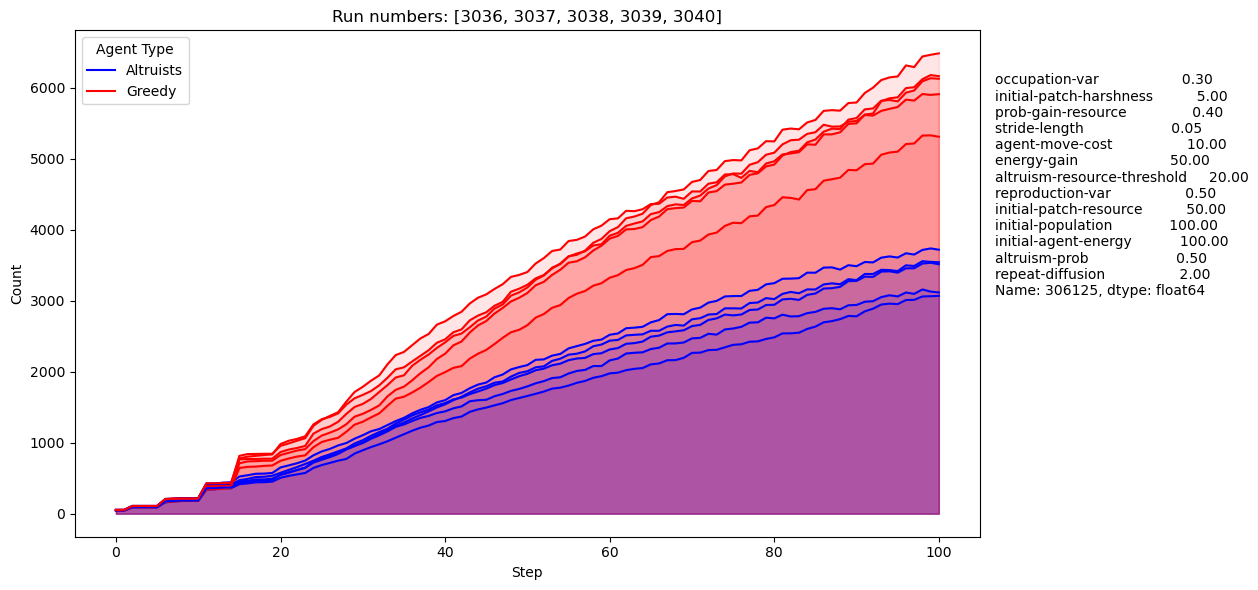

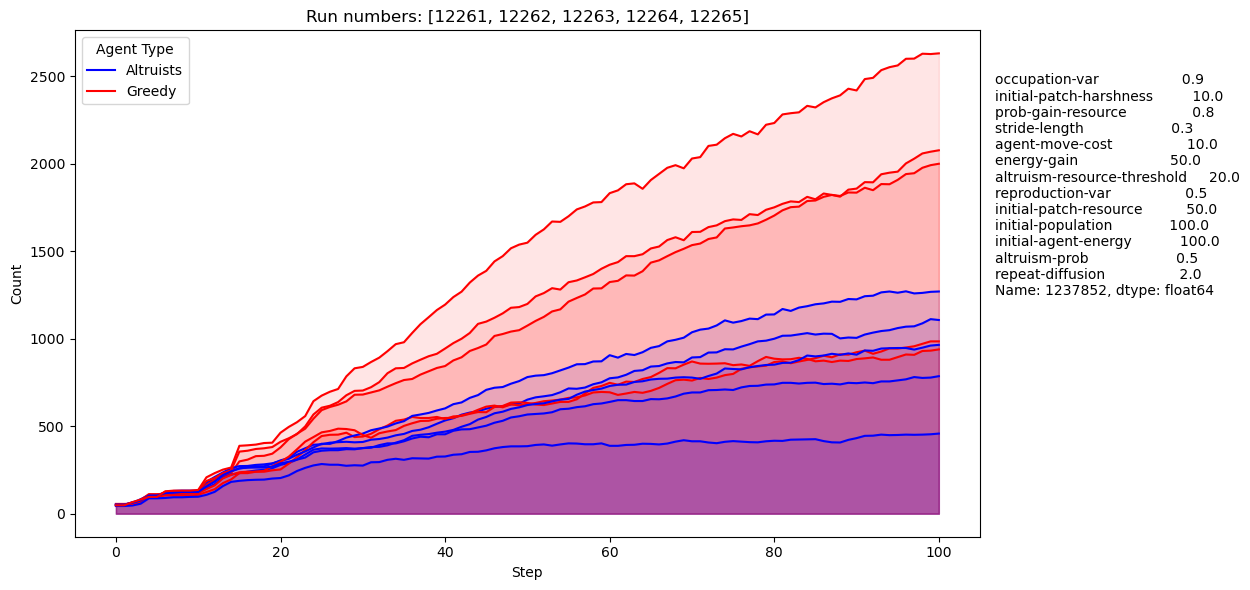

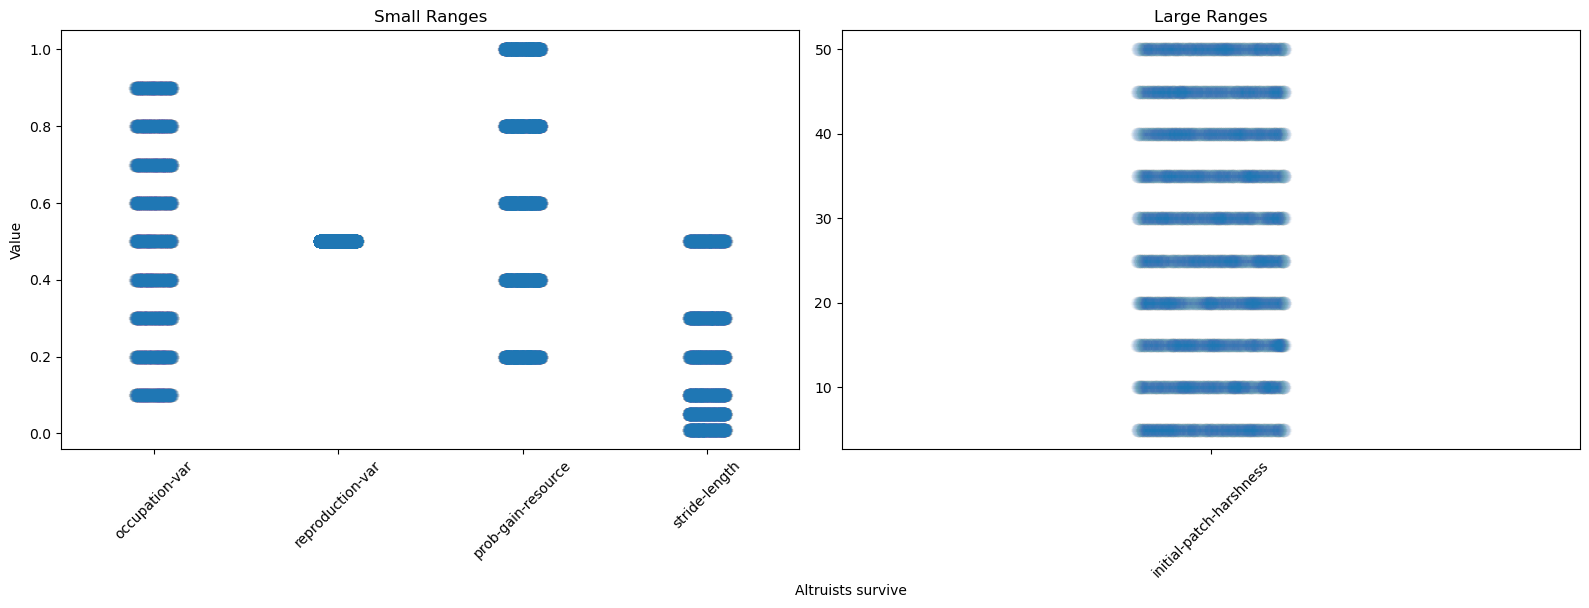

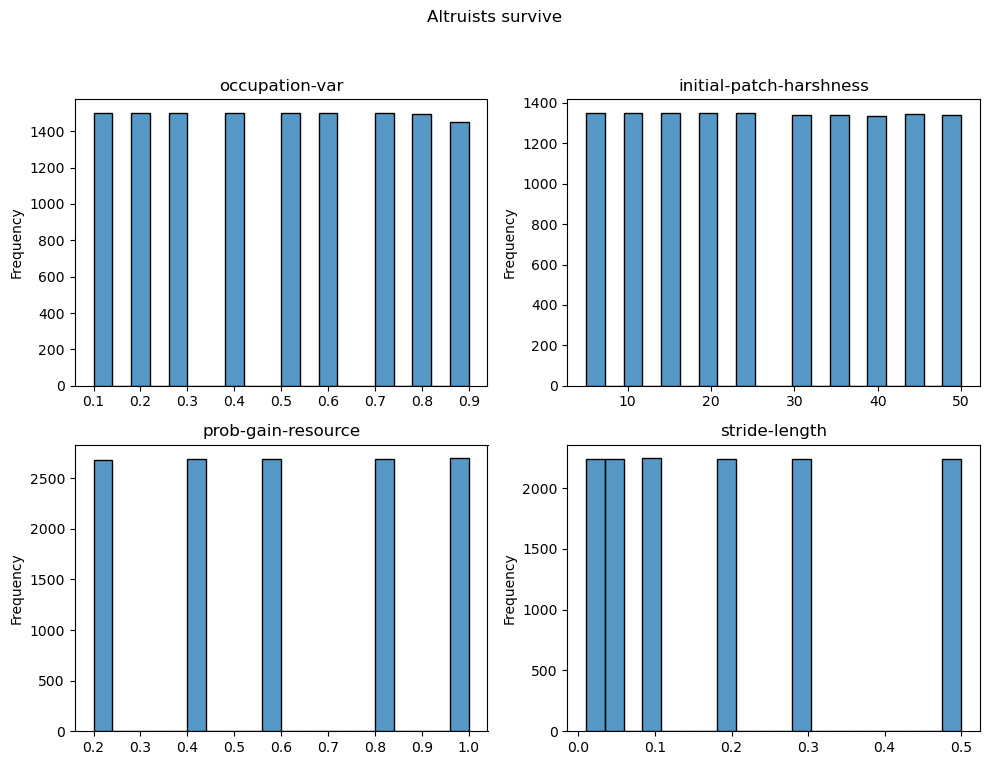

In [38]:
exp_altruists_survive = exp[exp['count altruism-agents'] > 0]
exp_full_alruists_survive = exp_full[exp_full['run-number'].isin(exp_altruists_survive['run-number'])]
print('Number of runs with surviving altruists:', len(exp_altruists_survive))
plot_random_experiment(exp_full_alruists_survive)
strip_plots(exp_altruists_survive, 'Altruists survive')
plot_histograms_grid(exp_altruists_survive, 'Altruists survive')

## More altruists than greedy agents

We can now start analysing the cases where the ratio between altruists and greedy agents is larger than some coefficient. Below, we check some cases where there are at least 20% more altruists after 100 iterations. 

Number of runs with surviving altruists: 218


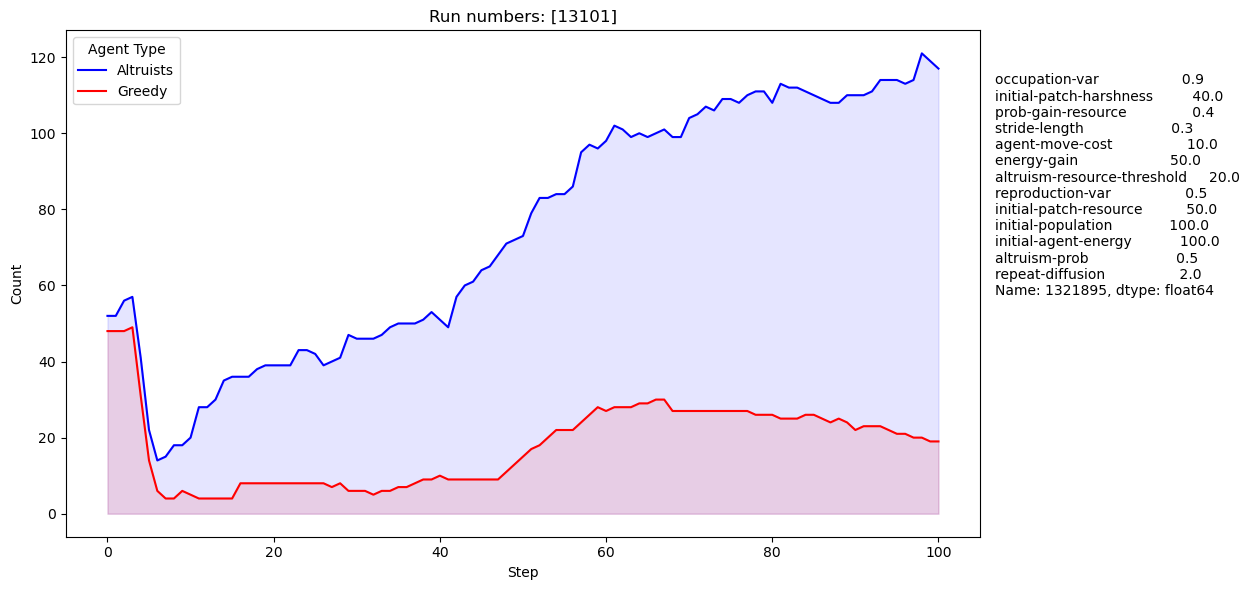

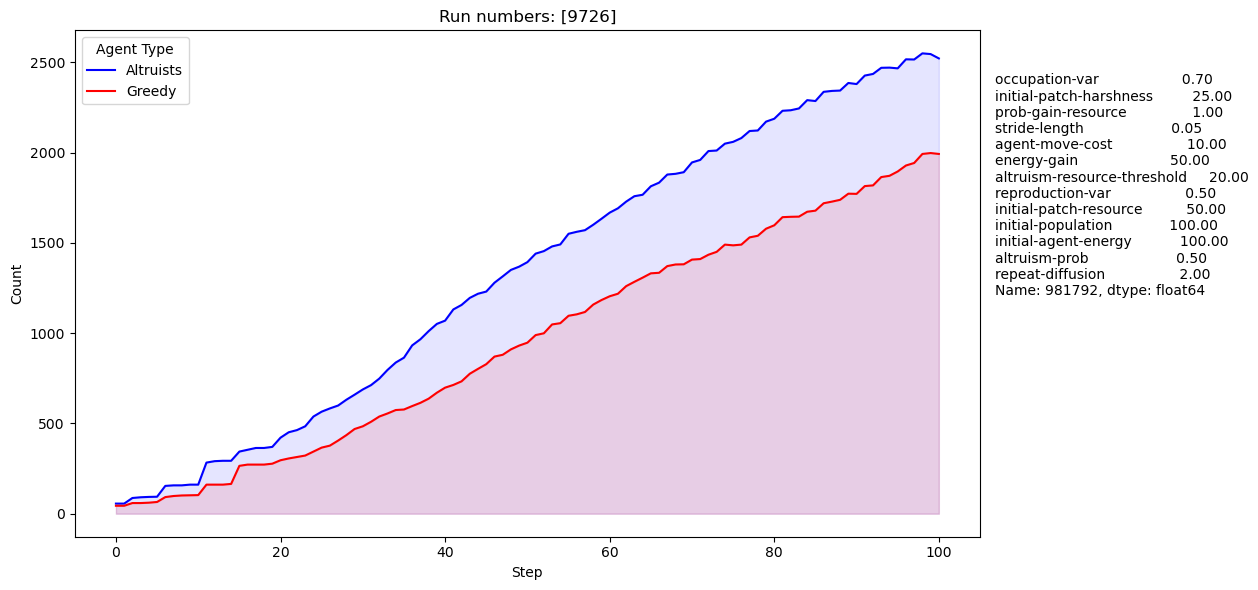

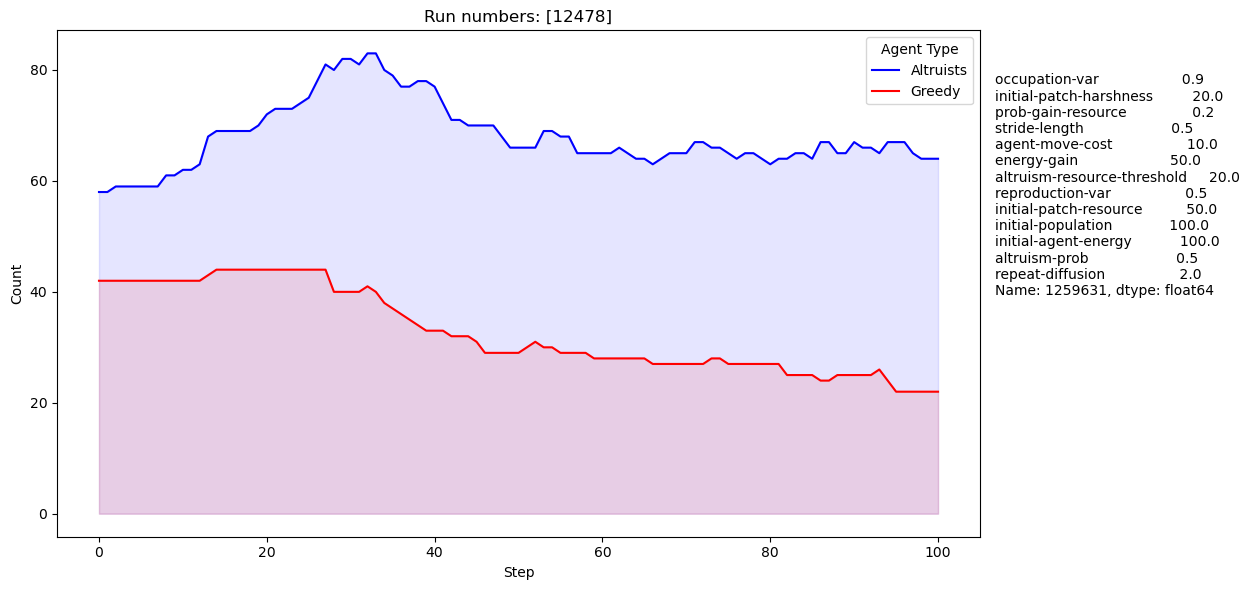

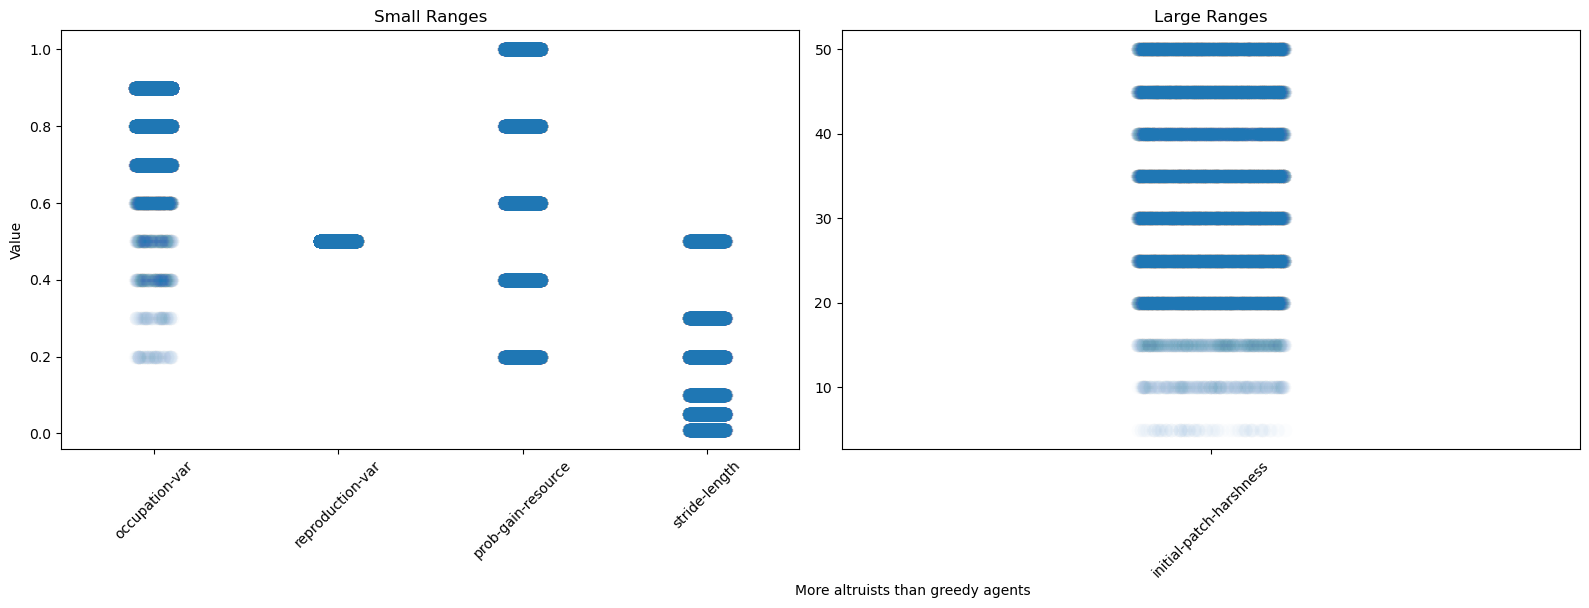

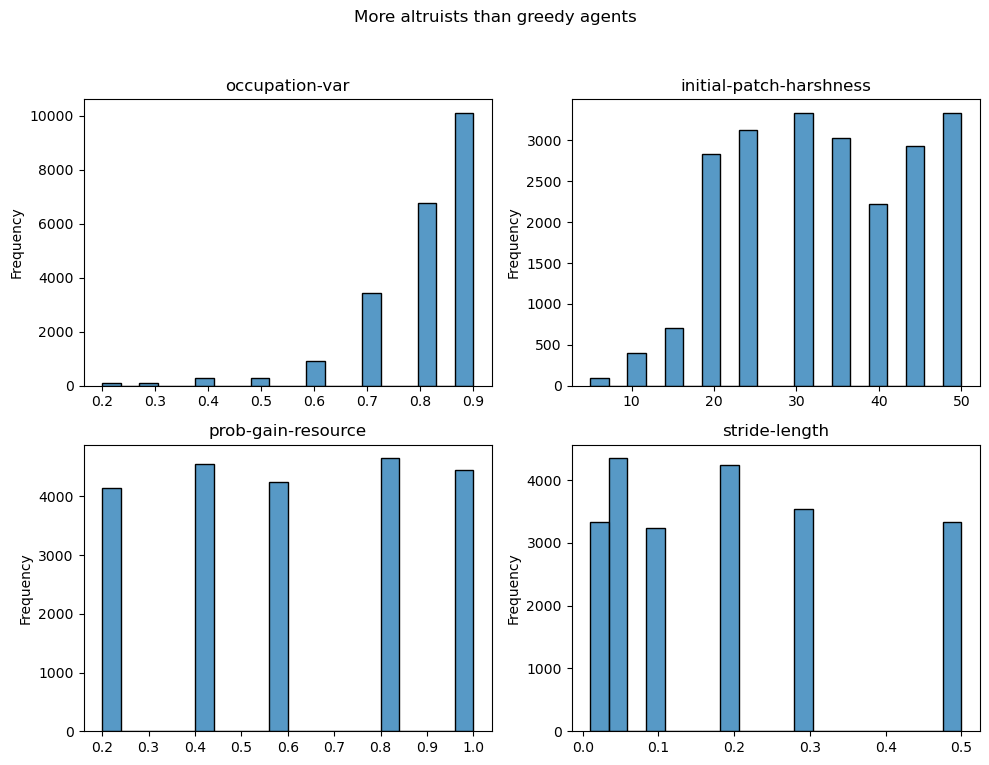

In [39]:
exp_more_altruists = exp[exp['count altruism-agents'] > 1.2 * exp['count greedy-agents']]
exp_full_more_altruists = exp_full[exp_full['run-number'].isin(exp_more_altruists['run-number'])]
print('Number of runs with surviving altruists:', len(exp_more_altruists))
plot_random_experiment(exp_full_more_altruists)
strip_plots(exp_full_more_altruists, 'More altruists than greedy agents')
plot_histograms_grid(exp_full_more_altruists, 'More altruists than greedy agents')

## Effect of variables on altruist ratio

Here we create a gif varying the ratio between the greedy agents and the altruists and looking at the spread of the parameters, the gif allows us to see which parameters are important.

In [40]:
def plot_histograms_grid_and_save(data, title, file_path):
    n_vars = len(varying_inputs)
    n_cols = 2
    n_rows = np.ceil(n_vars / n_cols).astype(int)
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(n_cols * 5, n_rows * 4))
    fig.suptitle(title)
    axes = axes.flatten()
    for i, var in enumerate(varying_inputs):
        sns.histplot(data[var], ax=axes[i], kde=False, bins=20)
        axes[i].set_title(var)
    for j in range(i + 1, n_rows * n_cols):
        axes[j].set_visible(False)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(file_path)
    plt.close()
    
def create_gif(frame_filenames, output_filename, duration=500):
    # Load frames
    frames = [Image.open(filename) for filename in frame_filenames]
    
    # Save as GIF
    frames[0].save(output_filename, format='GIF',
                   append_images=frames[1:],
                   save_all=True,
                   duration=duration, loop=0)

In [41]:
coefficients = np.arange(0.1, 1.6, 0.1) # Adjust the step if needed

frames = [] # To hold file names of the frames

FOLDER = Path('images_exp2')

for coeff in coefficients:
    filtered_df = exp[exp['count altruism-agents'] > coeff * exp['count greedy-agents']]
    file_name = f"hist_{coeff:.1f}.png"
    file_path = FOLDER/file_name
    plot_histograms_grid_and_save(filtered_df, f"Ratio of altruists over greedy agents larger than coeff: {coeff:.1f}", file_path)
    frames.append(file_path)
    

output_filename = FOLDER / 'animation_exp2.gif'
create_gif(frames, output_filename, duration=500)

### Effect of variables on altruism ratio

Below, we summarize the aforementioned GIF by plotting, for each coefficient value, the distribution of the variable values.

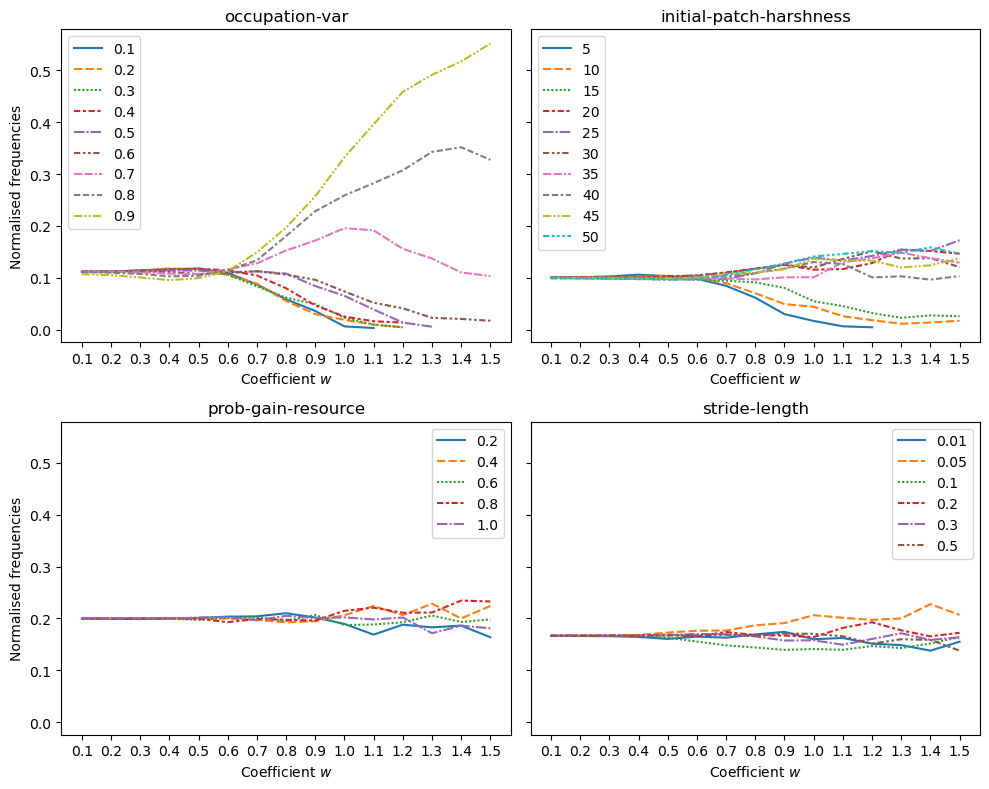

In [44]:
coefficients = np.arange(0.1, 1.6, 0.1) # Adjust the step if needed

n_vars = len(varying_inputs)
n_cols = 2
n_rows = np.ceil(n_vars / n_cols).astype(int)
fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(n_cols * 5, n_rows * 4), sharey=True)
axes = axes.flatten()

for var, ax in zip(varying_inputs, axes):
    unique_vals_var = {v: [] for v in exp[var].value_counts().index.values}
    for coeff in coefficients:
        filtered_df = exp[exp['count altruism-agents'] > coeff * exp['count greedy-agents']]
        counts = filtered_df[var].value_counts(normalize=True)
        for i, v in zip(counts.index.values, counts.values): 
            unique_vals_var[i].append(v)
    
    unique_vals_var = pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in unique_vals_var.items() ]))
    unique_vals_var.index = coefficients
    g = sns.lineplot(unique_vals_var, ax=ax)
    g.set_xticklabels(np.round(coefficients, 2))
    g.set_xticks(np.round(coefficients, 2))
    ax.set_title(var)
    ax.set_xlabel(r"Coefficient $w$")
    ax.set_ylabel("Normalised frequencies")

plt.tight_layout()
plt.savefig("images_exp2/sens_analysis_exp2.svg")

### Statistical test

We can obviously see that the distributions of the inputs change in the different data sets with different ratios of altruists. To make this a bit more rigorous, we perform chi2 tests for each combination of ratio coefficients. We also apply the Bonferonni correction to take into account the increased chance of type-I errors.

In [33]:
coefficients = np.arange(0.1, 1.6, 0.3) # Adjust the step if needed
num_tests = len(coefficients) * (len(coefficients) - 1) / 2 * len(varying_inputs)
print('Number of tests: ', num_tests)

def perform_chi_square_test(df1, df2, column, alpha, number_of_tests):
    # Combine and count occurrences in each category for the column
    combined_counts = pd.concat([df1[column].value_counts(), df2[column].value_counts()], axis=1, keys=['df1', 'df2'])
    
    # Perform Chi-square test
    chi2, p, dof, _ = chi2_contingency(combined_counts)
    
    # Bonferoni correction
    adjusted_alpha = alpha / number_of_tests
    
    reject_H_0 = p < adjusted_alpha
    
    return p, chi2, reject_H_0

results = []

for i, coeff1 in enumerate(coefficients):
    for coeff2 in coefficients[i+1:]:
        # Filter datasets by each coefficient
        df1 = exp[exp['count altruism-agents'] > coeff1 * exp['count greedy-agents']]
        df2 = exp[exp['count altruism-agents'] > coeff2 * exp['count greedy-agents']]
        
        assert df1.shape[0] > 50 and df2.shape[0] > 50, "Must have at least 50 samples for chi2 test"

        for column in varying_inputs:
            # Perform Chi-square test for the column
            p_value, chi2_statistic, reject_H_0 = perform_chi_square_test(df1, df2, column, alpha=0.05, number_of_tests=num_tests)
            if p_value is not None:
                results.append((coeff1, coeff2, column, p_value, chi2_statistic, reject_H_0))

# Convert results to DataFrame for easier viewing
results_df = pd.DataFrame(results, columns=['Coefficient 1', 'Coefficient 2', 'Column', 'P-Value', 'Chi2 Statistic', 'Reject H0'])
results_df

Number of tests:  40.0


,Coefficient 1,Coefficient 2,Column,P-Value,Chi2 Statistic,Reject H0
0,0.1,0.4,occupation-var,1.551827e-02,18.879368,False
1,0.1,0.4,initial-patch-harshness,9.767353e-01,2.644704,False
2,0.1,0.4,prob-gain-resource,9.991293e-01,0.084644,False
3,0.1,0.4,stride-length,9.980989e-01,0.274285,False
4,0.1,0.7,occupation-var,8.649518e-19,103.388958,True
5,0.1,0.7,initial-patch-harshness,3.298730e-02,18.194097,False
6,0.1,0.7,prob-gain-resource,9.549289e-01,0.670396,False
7,0.1,0.7,stride-length,1.490911e-01,8.132345,False
8,0.1,1.0,occupation-var,4.531917e-99,482.242777,True
9,0.1,1.0,initial-patch-harshness,1.108614e-14,85.839905,True


We reject the hypothesis that the input parameters have the same distribution in the below cases.

In [34]:
results_df[results_df['Reject H0']]

,Coefficient 1,Coefficient 2,Column,P-Value,Chi2 Statistic,Reject H0
4,0.1,0.7,occupation-var,8.649518e-19,103.388958,True
8,0.1,1.0,occupation-var,4.531917e-99,482.242777,True
9,0.1,1.0,initial-patch-harshness,1.108614e-14,85.839905,True
16,0.4,0.7,occupation-var,3.431338e-31,163.195642,True
20,0.4,1.0,occupation-var,3.810888e-114,552.479532,True
21,0.4,1.0,initial-patch-harshness,9.720516e-16,91.115767,True
28,0.7,1.0,occupation-var,1.916178e-51,259.212982,True
29,0.7,1.0,initial-patch-harshness,8.994105e-10,60.898869,True


Therefore, it seems that the following inputs have an effect on the altruism ratio

In [35]:
results_df[results_df['Reject H0']]['Column'].unique()

array(['occupation-var', 'initial-patch-harshness'], dtype=object)